In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count, concat_ws, length, rand
import pandas as pd

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [3]:
spark = SparkSession.builder \
    .appName("RAID-EDA") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [4]:
df = spark.read.json("hdfs://namenode:8020/user/raid/raw")
df

DataFrame[adv_source_id: string, attack: string, decoding: string, domain: string, generation: string, id: string, model: string, prompt: string, repetition_penalty: string, source_id: string, title: string]

In [5]:
df.printSchema()

root
 |-- adv_source_id: string (nullable = true)
 |-- attack: string (nullable = true)
 |-- decoding: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- generation: string (nullable = true)
 |-- id: string (nullable = true)
 |-- model: string (nullable = true)
 |-- prompt: string (nullable = true)
 |-- repetition_penalty: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- title: string (nullable = true)



# Total Baris

In [7]:
print("[1] Menghitung total jumlah baris...")
total_rows, time_1 = measure_time(lambda: df.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_1:.4f} detik")

[1] Menghitung total jumlah baris...
✅ Total baris: 5,615,820 | Waktu: 4.7673 detik


# Cek missing values

In [7]:
print("[2] Cek missing values (null) per kolom...")
missing_counts, time_2 = measure_time(
    lambda: df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
)
print(f"✅ Selesai dalam {time_2:.4f} detik")
missing_dict = missing_counts[0].asDict()
for col_name, null_count in missing_dict.items():
    print(f"  - {col_name}: {null_count:,} nulls")

[2] Cek missing values (null) per kolom...
✅ Selesai dalam 12.8447 detik
  - adv_source_id: 0 nulls
  - attack: 0 nulls
  - decoding: 160,452 nulls
  - domain: 0 nulls
  - generation: 0 nulls
  - id: 0 nulls
  - model: 0 nulls
  - prompt: 160,452 nulls
  - repetition_penalty: 160,452 nulls
  - source_id: 0 nulls
  - title: 0 nulls


# Distribusi 'model'

[3] Distribusi 'model'...
✅ Selesai dalam 10.2431 detik
Jumlah nilai unik 'model': 12


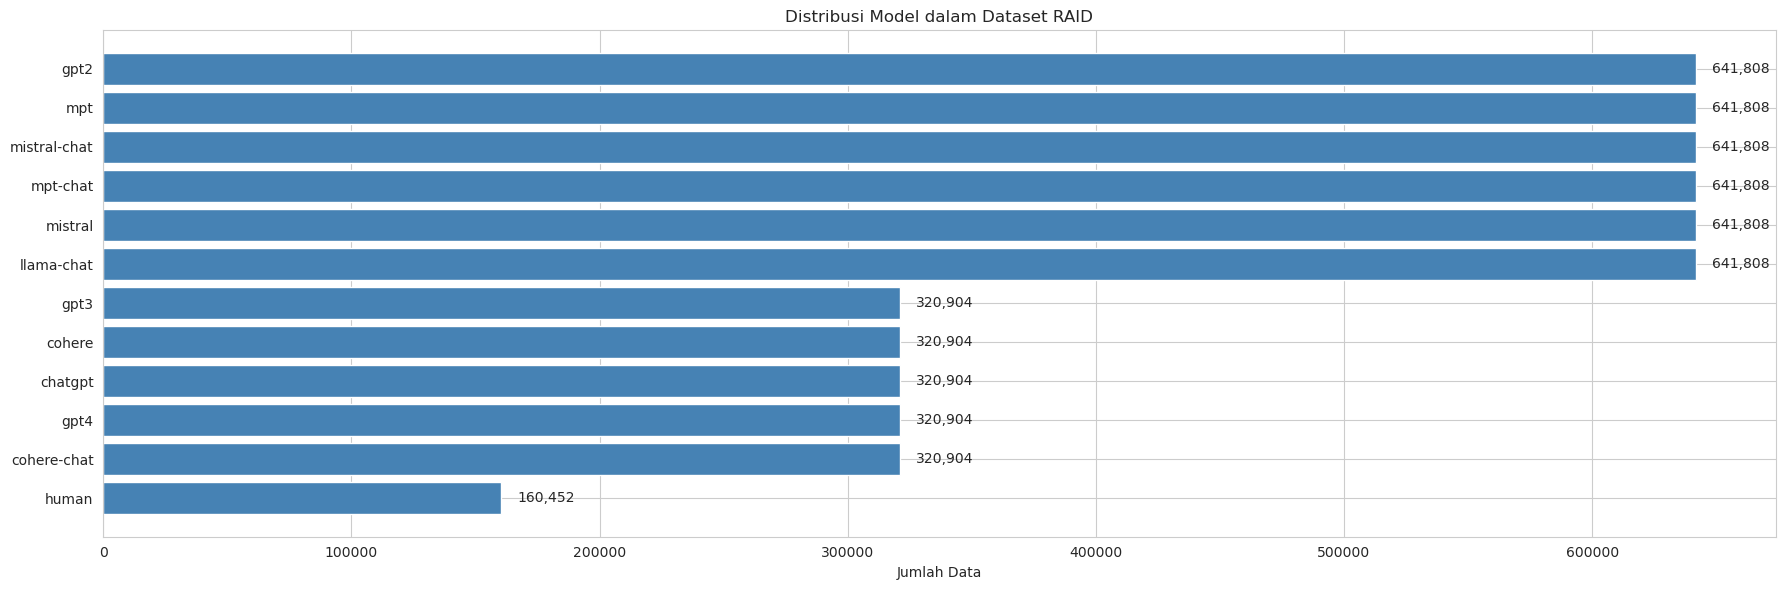

In [9]:
print("[3] Distribusi 'model'...")
model_dist, time_3 = measure_time(
    lambda: df.groupBy("model").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_3:.4f} detik")

models = [row['model'] for row in model_dist]
counts = [row['count'] for row in model_dist]
print(f"Jumlah nilai unik 'model': {len(models)}")

# Plot
plt.figure(figsize=(18, max(6, len(models) * 0.3)))
sns.set_style("whitegrid")
plt.barh(models, counts, color='steelblue')
plt.xlabel('Jumlah Data')
plt.title('Distribusi Model dalam Dataset RAID')
plt.gca().invert_yaxis()
for i, count in enumerate(counts):
    plt.text(count + max(counts) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi 'domain'

[4] Distribusi 'domain'...
✅ Selesai dalam 6.7870 detik


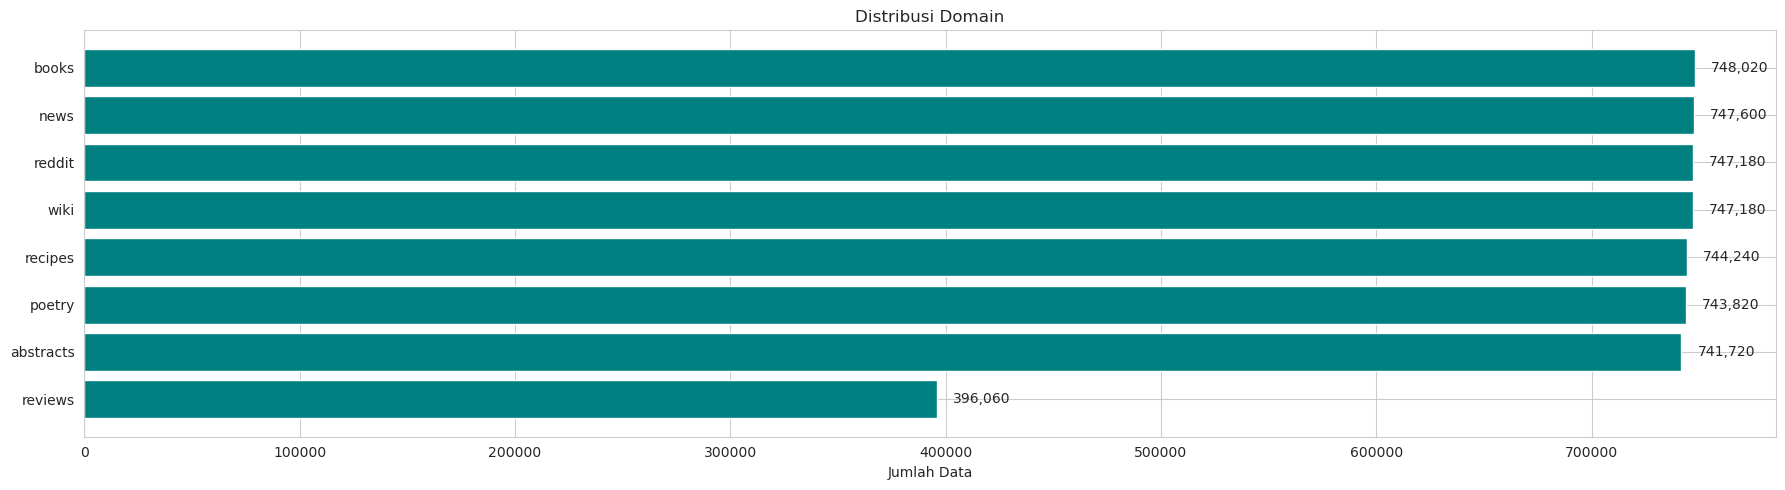

In [12]:
print("[4] Distribusi 'domain'...")
domain_dist, time_4 = measure_time(
    lambda: df.groupBy("domain").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_4:.4f} detik")

domains = [row['domain'] for row in domain_dist]
d_counts = [row['count'] for row in domain_dist]

plt.figure(figsize=(18, max(5, len(domains) * 0.25)))
sns.set_style("whitegrid")
plt.barh(domains, d_counts, color='teal')
plt.xlabel('Jumlah Data')
plt.title('Distribusi Domain')
plt.gca().invert_yaxis()
for i, count in enumerate(d_counts):
    plt.text(count + max(d_counts) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi 'attack'

[5] Distribusi 'attack'...
✅ Selesai dalam 6.6108 detik


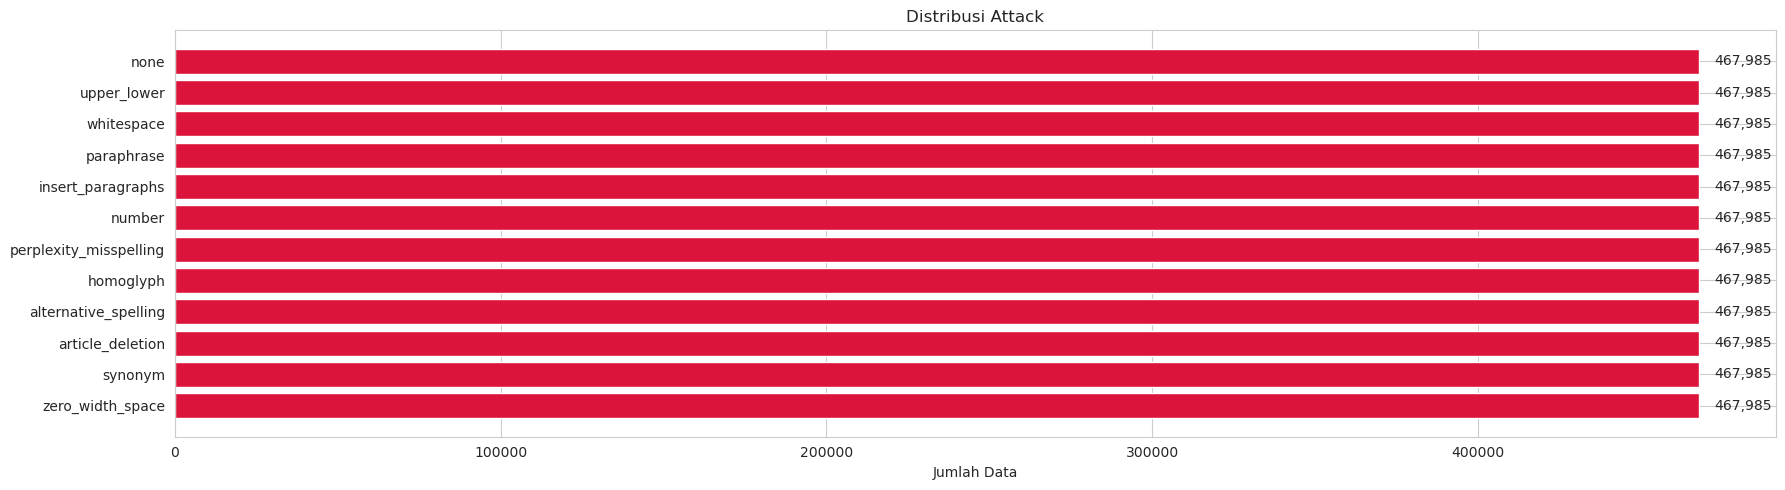

In [13]:
print("[5] Distribusi 'attack'...")
attack_dist, time_5 = measure_time(
    lambda: df.groupBy("attack").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_5:.4f} detik")

attacks = [row['attack'] for row in attack_dist]
a_counts = [row['count'] for row in attack_dist]

plt.figure(figsize=(18, max(5, len(attacks) * 0.25)))
sns.set_style("whitegrid")
plt.barh(attacks, a_counts, color='crimson')
plt.xlabel('Jumlah Data')
plt.title('Distribusi Attack')
plt.gca().invert_yaxis()
for i, count in enumerate(a_counts):
    plt.text(count + max(a_counts) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi Gabungan 'model_domain'

In [40]:
print("[6] Distribusi gabungan 'model_domain'...")
df_md = df.withColumn("model_domain", concat_ws("_", col("model"), col("domain")))
md_dist, time_6 = measure_time(
    lambda: df_md.groupBy("model_domain").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_6:.4f} detik")
print(f"Jumlah kombinasi unik 'model_domain': {len(md_dist)}")

[6] Distribusi gabungan 'model_domain'...
✅ Selesai dalam 7.0301 detik
Jumlah kombinasi unik 'model_domain': 96


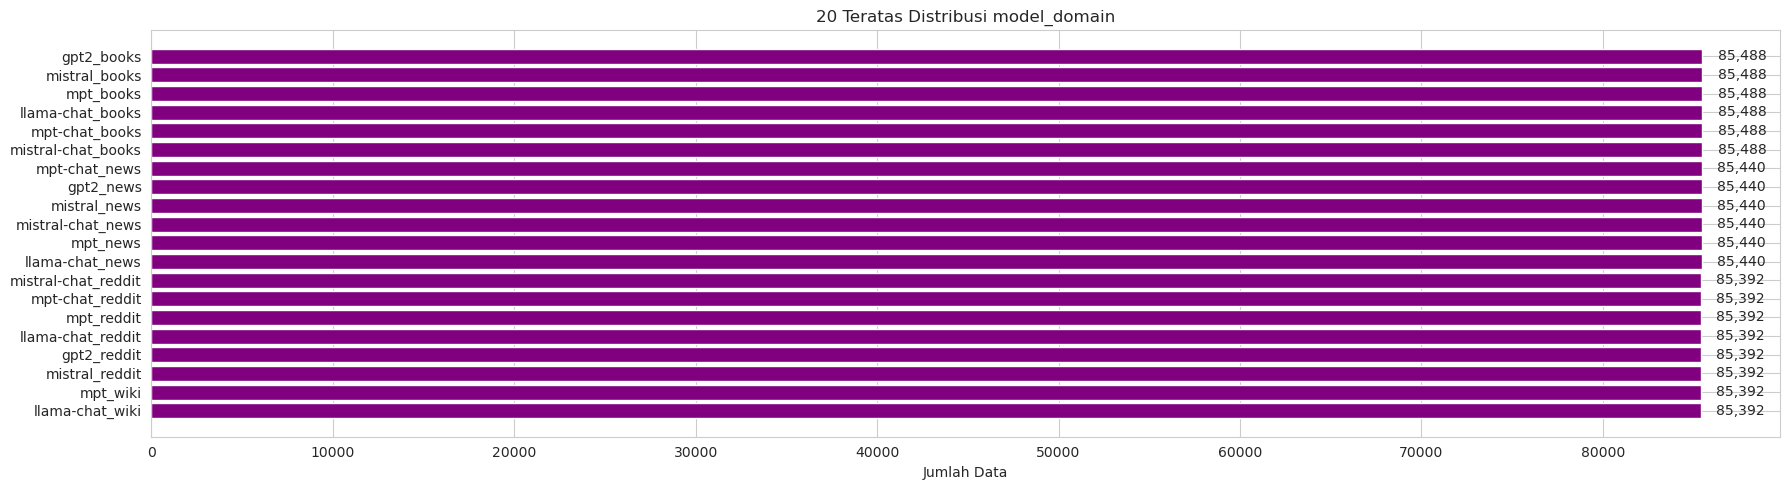

In [45]:
md_show = md_dist[:20] if len(md_dist) > 10 else md_dist
md_labels = [row['model_domain'] for row in md_show]
md_vals = [row['count'] for row in md_show]

plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")
plt.barh(md_labels, md_vals, color='purple')
plt.xlabel('Jumlah Data')
plt.title('20 Teratas Distribusi model_domain')
plt.gca().invert_yaxis()
for i, count in enumerate(md_vals):
    plt.text(count + max(md_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

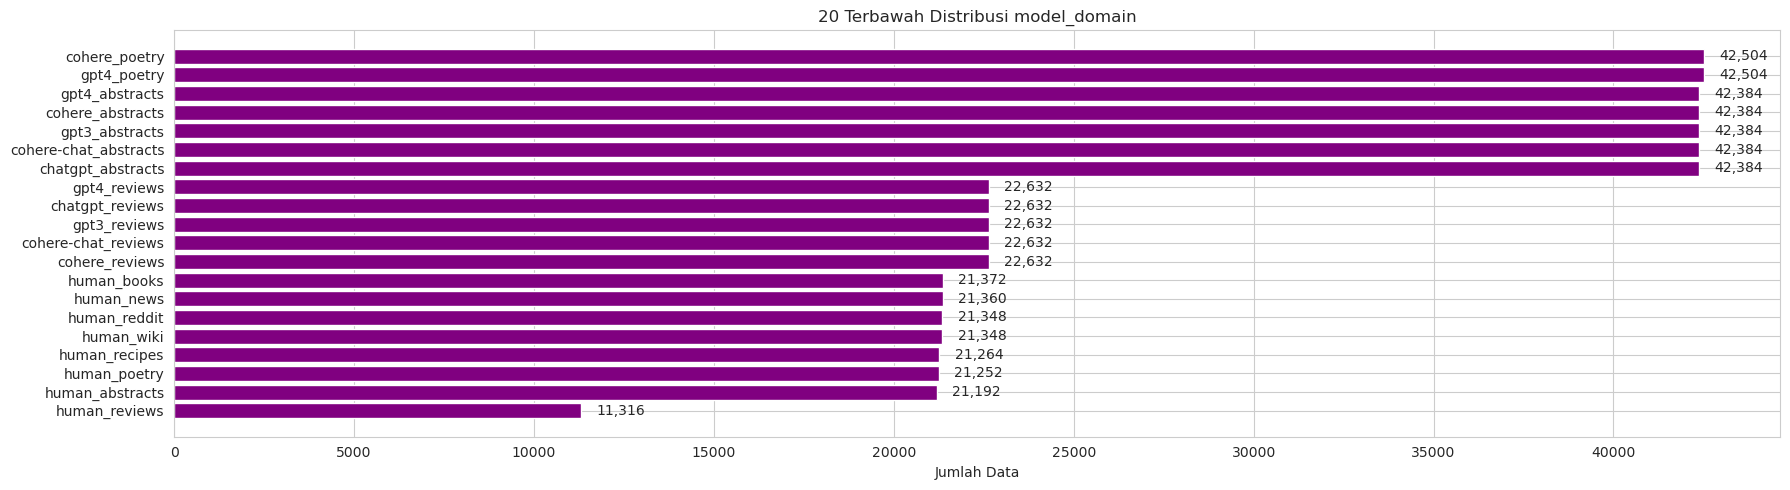

In [46]:
md_show = md_dist[len(md_dist) - 20:] if len(md_dist) > 10 else md_dist
md_labels = [row['model_domain'] for row in md_show]
md_vals = [row['count'] for row in md_show]

plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")
plt.barh(md_labels, md_vals, color='purple')
plt.xlabel('Jumlah Data')
plt.title('20 Terbawah Distribusi model_domain')
plt.gca().invert_yaxis()
for i, count in enumerate(md_vals):
    plt.text(count + max(md_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi Gabungan 'model_attack'

In [52]:
print("[7] Distribusi gabungan 'model_attack'...")
df_ma = df.withColumn("model_attack", concat_ws("_", col("model"), col("attack")))
ma_dist, time_7 = measure_time(
    lambda: df_ma.groupBy("model_attack").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_7:.4f} detik")
print(f"Jumlah kombinasi unik 'model_attack': {len(ma_dist)}")

[7] Distribusi gabungan 'model_attack'...
✅ Selesai dalam 5.7429 detik
Jumlah kombinasi unik 'model_attack': 144


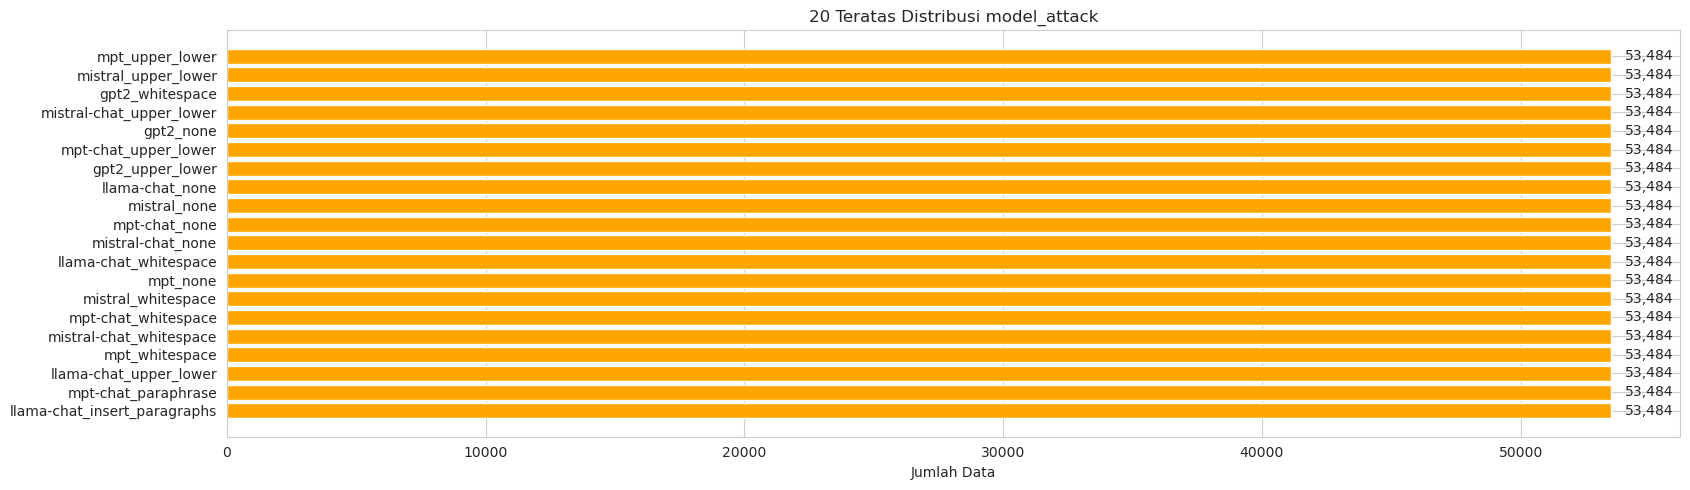

In [47]:
ma_show = ma_dist[:20] if len(ma_dist) > 10 else ma_dist
ma_labels = [row['model_attack'] for row in ma_show]
ma_vals = [row['count'] for row in ma_show]

plt.figure(figsize=(17, 5))
sns.set_style("whitegrid")
plt.barh(ma_labels, ma_vals, color='orange')
plt.xlabel('Jumlah Data')
plt.title('20 Teratas Distribusi model_attack')
plt.gca().invert_yaxis()
for i, count in enumerate(ma_vals):
    plt.text(count + max(ma_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

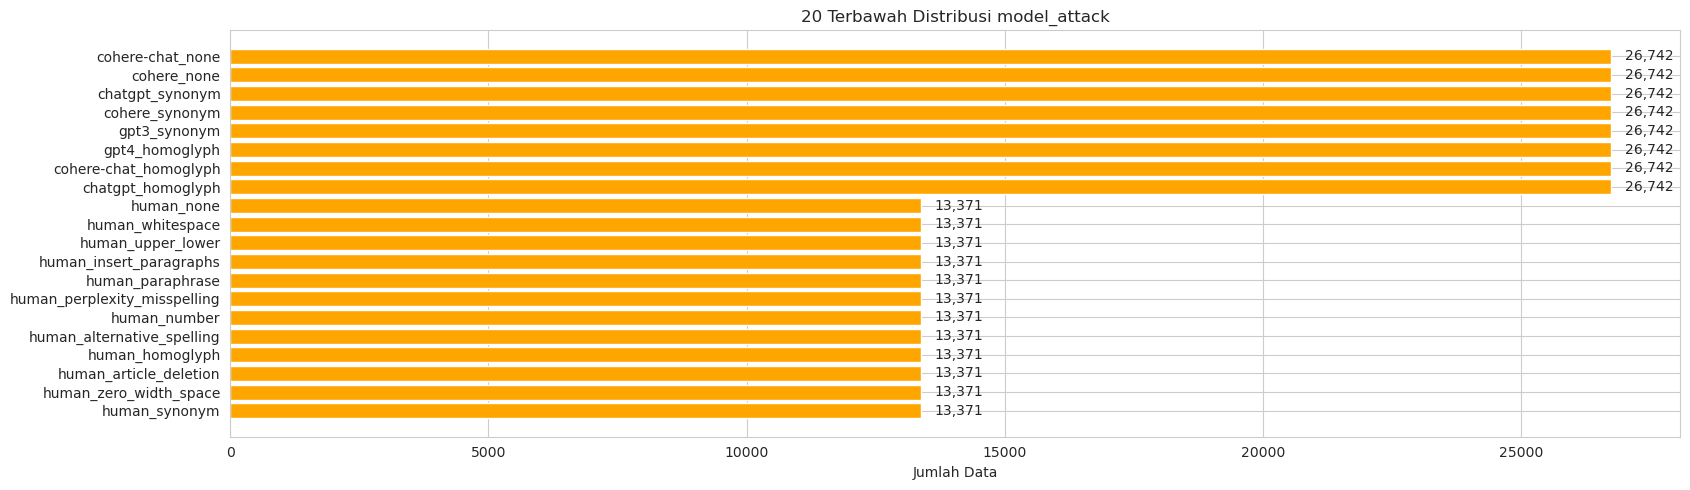

In [49]:
ma_show = ma_dist[len(ma_dist) - 20:]
ma_labels = [row['model_attack'] for row in ma_show]
ma_vals = [row['count'] for row in ma_show]

plt.figure(figsize=(17, 5))
sns.set_style("whitegrid")
plt.barh(ma_labels, ma_vals, color='orange')
plt.xlabel('Jumlah Data')
plt.title('20 Terbawah Distribusi model_attack')
plt.gca().invert_yaxis()
for i, count in enumerate(ma_vals):
    plt.text(count + max(ma_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi Gabungan 'model_domain_attack'

In [50]:
print("[8] Distribusi gabungan 'model_domain_attack'...")
df_mda = df.withColumn(
    "model_domain_attack",
    concat_ws("_", col("model"), col("domain"), col("attack"))
)
mda_dist, time_8 = measure_time(
    lambda: df_mda.groupBy("model_domain_attack").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_8:.4f} detik")
print(f"Jumlah kombinasi unik 'model_domain_attack': {len(mda_dist)}")

[8] Distribusi gabungan 'model_domain_attack'...
✅ Selesai dalam 5.8944 detik
Jumlah kombinasi unik 'model_domain_attack': 1152


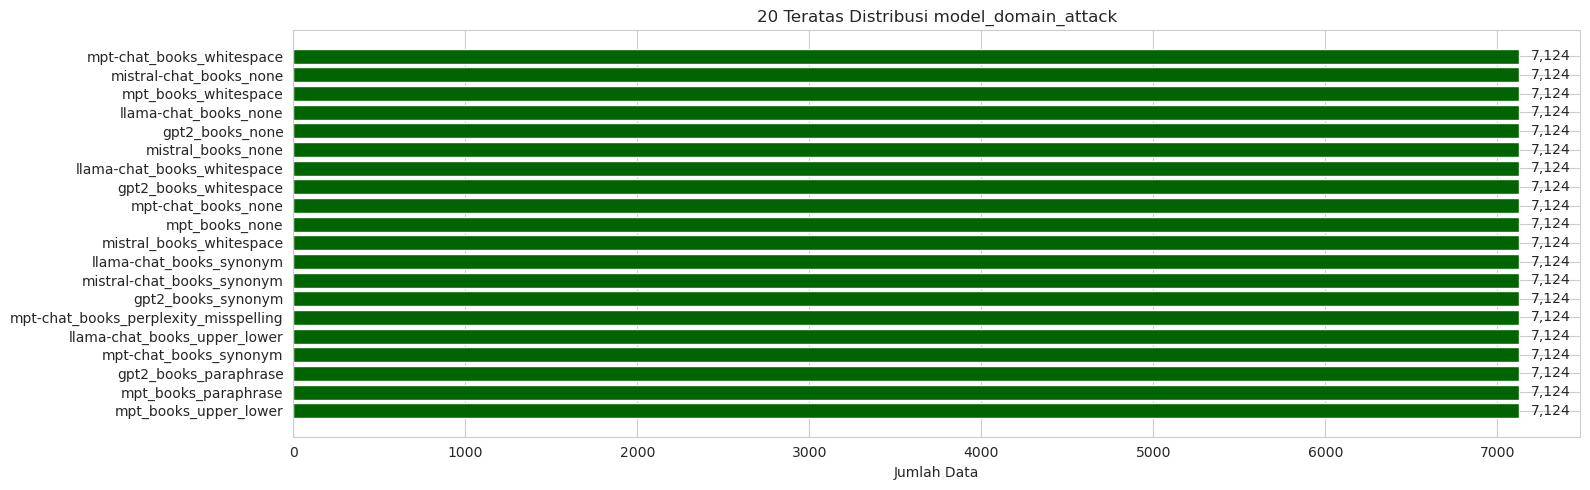

In [53]:
mda_show = mda_dist[:20] if len(mda_dist) > 10 else mda_dist
mda_labels = [row['model_domain_attack'] for row in mda_show]
mda_vals = [row['count'] for row in mda_show]

plt.figure(figsize=(16, 5))
sns.set_style("whitegrid")
plt.barh(mda_labels, mda_vals, color='darkgreen')
plt.xlabel('Jumlah Data')
plt.title('20 Teratas Distribusi model_domain_attack')
plt.gca().invert_yaxis()
for i, count in enumerate(mda_vals):
    plt.text(count + max(mda_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

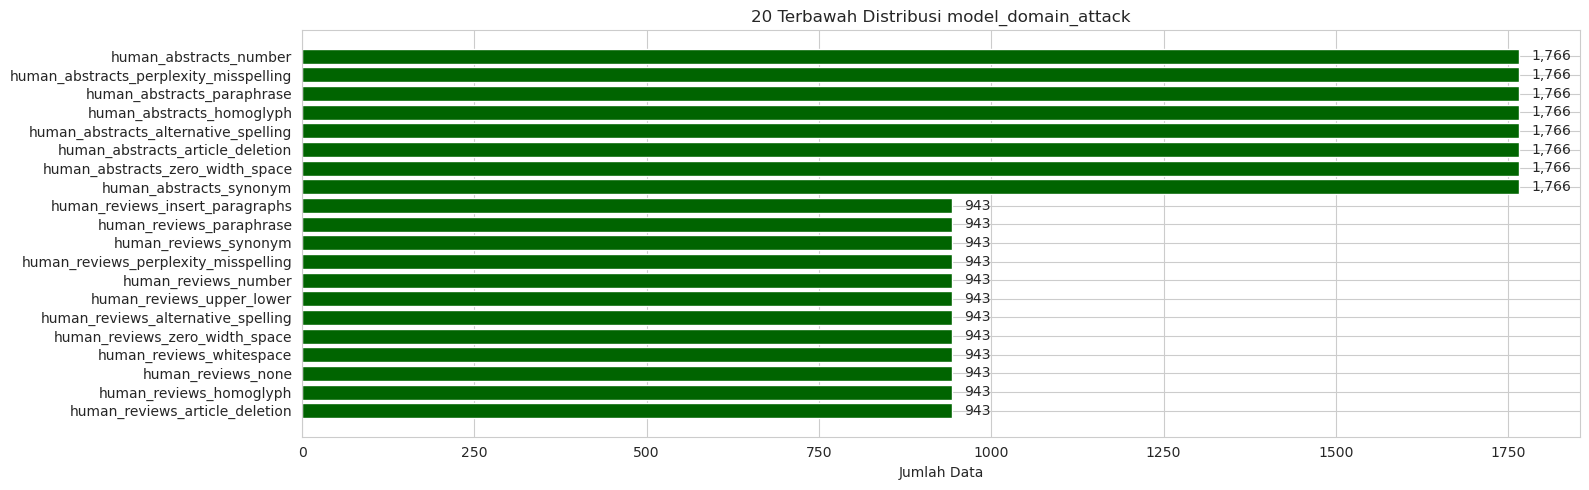

In [54]:
mda_show = mda_dist[len(mda_dist) - 20:]
mda_labels = [row['model_domain_attack'] for row in mda_show]
mda_vals = [row['count'] for row in mda_show]

plt.figure(figsize=(16, 5))
sns.set_style("whitegrid")
plt.barh(mda_labels, mda_vals, color='darkgreen')
plt.xlabel('Jumlah Data')
plt.title('20 Terbawah Distribusi model_domain_attack')
plt.gca().invert_yaxis()
for i, count in enumerate(mda_vals):
    plt.text(count + max(mda_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Panjang Teks 'generation'

In [56]:
print("[9] Panjang teks pada kolom 'generation'...")
# Catatan: 'generation' berisi label 'human'/'machine', bukan teks panjang
gen_len_stats, time_9 = measure_time(
    lambda: df.select(
        pyspark.sql.functions.min(length(col("generation"))).alias("min_len"),
        pyspark.sql.functions.max(length(col("generation"))).alias("max_len")
    ).collect()
)
stats = gen_len_stats[0]
print(f"✅ Min: {stats['min_len']}, Max: {stats['max_len']} | Waktu: {time_9:.4f} detik")

[9] Panjang teks pada kolom 'generation'...
✅ Min: 1, Max: 140088 | Waktu: 11.0981 detik


# 100 Contoh Data Acak

In [59]:
print("[10] Menampilkan 100 contoh data acak...")
sample_pd, time_10 = measure_time(
    lambda: df.orderBy(rand()).limit(100).toPandas()
)
print(f"✅ Selesai dalam {time_10:.4f} detik")
print("Contoh data:")
display(sample_pd)

[10] Menampilkan 100 contoh data acak...
✅ Selesai dalam 10.7796 detik
Contoh data:


,adv_source_id,attack,decoding,domain,generation,id,model,prompt,repetition_penalty,source_id,title
0,0660327b-4582-4090-88b0-b496407ae589,paraphrase,sampling,news,As England fights to maintain her hold on Euro...,b91c69f3-26a3-4f82-a2e1-ff7cdf414449,mpt-chat,"Write the body of a BBC news article titled ""E...",yes,8cfa1ccf-7656-486f-a497-349d4189015e,England's defensive crisis grows
1,0c5f4576-33c2-4dbf-9865-3253a5d1ac9e,article_deletion,greedy,reviews,I'm not sure if it was because this film came ...,6fb0c202-dc02-4776-8178-d3e0b80e98f3,mistral,The following is the full text of a review for...,yes,84677ad2-f99e-4856-9d47-27191eb19c2f,Rocky
2,9cc9775f-85e1-471b-83d2-a7b21a419237,whitespace,sampling,news,A teenager whose home was raided by armed po...,bcf9df1b-bc3c-47f8-b044-38e60830b61f,mpt,The following is the full text of a news artic...,yes,00a84a82-e52d-4260-ae8b-4b6dea908df7,Police praise 'courageous' Ozzy
3,6933c5ed-5db7-4726-a219-c2067d73bdd1,homoglyph,greedy,wiki,\n\nΤhе Τhоrstеіn Vеblеn Fаrmstеаd іs а hіstоr...,eee768f1-c4ba-472c-950a-d1b0fc766c1b,gpt3,The following is the full text of an article t...,no,7ed1289e-ccf7-4da2-a012-746967b3f125,Thorstein Veblen Farmstead
4,176567d5-fcdb-44ea-ade5-6d110f18ad77,homoglyph,greedy,wiki,"Кіm Нуdе (bоrn Νоvеmbеr 15, 1960) іs аn Аmеrіс...",5adcf853-5e7a-480d-a7bc-721a600e17c3,mpt,The following is the full text of an article t...,no,84523533-7c18-4507-9f8b-7c2d9122ab91,Kim Hyde
...,...,...,...,...,...,...,...,...,...,...,...
95,a8deebb9-41f8-4633-8987-8e544810a92f,zero_width_space,greedy,poetry,I​ ​a​m​ ​n​o​t​ ​s​u​r​e​ ​w​h​a​t​ ​I​ ​w​a​...,63b3ede0-3914-4cf3-aefa-83e276628236,gpt2,The following is the full text of a poem title...,yes,67bba215-fd9a-42ae-9510-404063bf0bce,The Future
96,7d946206-6ef1-41b1-b0e5-04de1ad43a90,insert_paragraphs,greedy,reviews,"I recently watched ""Happy Gilmore"" for the fir...",a199ef6b-9ac0-4b69-98fa-e05e05f9f7e1,llama-chat,Write the body of an IMDb review for the movie...,no,ba682fb6-a587-49e2-a36f-566e1c8986e9,Happy Gilmore
97,907b2f3f-d190-41e7-9a87-00644740b265,alternative_spelling,sampling,news,Valencia have announced that they have parted ...,1a9027f8-e578-40b2-acfb-888c241e9c56,mpt-chat,"Write the body of a BBC news article titled ""C...",yes,b19594b3-39ab-4d81-8638-38fc330520a3,Coach Ranieri sacked by Valencia
98,4a27ea41-65b6-4a41-a844-cb8b2eb35657,article_deletion,greedy,poetry,"In the realm of hearts entwined,\nWhere passio...",22a85b19-3c33-4388-8c36-276432bfe8bb,chatgpt,"Write the body of a poem titled ""Love Romantic...",no,658277a3-55d1-4dfa-aae8-11ffd88597d7,Love Romantic
